<h1 align = "center">GEAR Network</h1>
<h4 align = "center">Jiarui Xu - jxu57@illinois.edu</h4>

In [1]:
%matplotlib inline

In [2]:
import scrapy
import requests
import urllib2
import BeautifulSoup
import pickle
import pyprind
import json
import collections
import matplotlib.pyplot as plt

In [4]:
import mathscinet

# Load basic infomation

In [26]:
with open("original_profile.json") as f:
    orig_profile = json.load(f)

# Retrieve papers for each professor

### Construct paper_set: mathsci_id -> paper_list mapping

In [7]:
bar = pyprind.ProgBar(len(orig_profile['items']), bar_char='█', width=70)

paper_set = {}

for person in orig_profile['items']:
    
    bar.update()
    
    member_id = person['member_id']
    mathsci_id = person['mathsci_id']
    
    if mathsci_id != 'NA':
        paper_set[mathsci_id] = mathscinet.find_papers(mathsci_id)

0%                                                                  100%
[██████████████████████████████████████████████████████████████████████] | ETA: 00:00:00
Total time elapsed: 00:04:38


In [8]:
with open("mathscinet_paper_base.json", "wb") as f:
    json.dump(paper_set, f)

In [9]:
with open("mathscinet_paper_base.json", "rb") as f:
    paper_set = json.load(f)

# Profile Update

### 1. Retrieving papers

In [10]:
paper_set_2011 = {}
count_2011 = 0

for mathsci_id in paper_set.keys():
    
    paper_set_2011[mathsci_id] = []
    
    for paper in paper_set[mathsci_id]:
        if paper['year'] >= 2011:
            count_2011 += 1
            paper_set_2011[mathsci_id].append(paper)

print "Completed! count:", count_2011

Completed! count: 1476


### 2. Retrieving citations

In [11]:
bar = pyprind.ProgBar(count_2011, bar_char='█', width=70)

for mathsci_id in paper_set_2011.keys():
    
    for paper in paper_set_2011[mathsci_id]:
        bar.update()
        paper['citing'] = mathscinet.find_children_citations(paper['article_id'])

0%                                                                  100%
[██████████████████████████████████████████████████████████████████████] | ETA: 00:00:00
Total time elapsed: 00:17:56


In [12]:
with open("mathscinet_paper_base_with_citation.json", "wb") as f:
    json.dump(paper_set_2011, f)

In [13]:
with open("mathscinet_paper_base_with_citation.json", "rb") as f:
    paper_set_2011 = json.load(f)

### 3. Updating the profile accordingly 

In [14]:
# build mapping id_converter: mathsci_id -> member_id

id_converter = {}

for person in orig_profile['items']:
    id_converter[person['mathsci_id']] = person['member_id']

#### 3.1 Update collaborator

In [15]:
def update_collaborators(cprofile, cpaper_set, starting_year, ending_year, converter):
    col_key = "%s-%s collaborators stats" % (str(starting_year), str(ending_year))
    print col_key
    for person in cprofile['items']:
        
        collab_list = []
        
        mathsci_id = person['mathsci_id']
        if mathsci_id == "NA":
            continue
        for paper in cpaper_set[mathsci_id]:
            year = paper['year']
            if year < starting_year or year > ending_year:
                continue
            authors = ["MR"+au for au in paper['authors']]
            for au in authors:
                if au in converter:
                    collab_list.append(converter[au])
                    
        person[col_key] = dict(collections.Counter(collab_list))
        
    print "Done"

In [16]:
for ending_year in range(2011, 2016):
    update_collaborators(orig_profile, paper_set_2011, 2011, ending_year, id_converter)

2011-2011 collaborators stats
Done
2011-2012 collaborators stats
Done
2011-2013 collaborators stats
Done
2011-2014 collaborators stats
Done
2011-2015 collaborators stats
Done


#### 3.2 Update citation

In [17]:
def retrieve_citations(person, cpaper_set, starting_year, ending_year):
    
    mathsci_id = person['mathsci_id']
    
    ret = []
    
    if mathsci_id == "NA":
        return ret
    
    paper_list = cpaper_set[mathsci_id]
    
    for paper in paper_list:
        year = paper['year']
        if year < starting_year or year > ending_year:
            continue
        ret.extend(paper['citing'])
        
    return ret

In [18]:
def list_overlap(list_a, list_b):

    a_multiset = collections.Counter(list_a)
    b_multiset = collections.Counter(list_b)

    overlap = list((a_multiset & b_multiset).elements())
    
    return overlap

In [19]:
def update_citations(cprofile, cpaper_set, starting_year, ending_year, converter):
    
    cit_key = "%s-%s citation stats" % (str(starting_year), str(ending_year))
    print cit_key    
    
    # build member_id -> person mapping
    temp_profile = {}
    for person in cprofile['items']:
        member_id = person['member_id']
        temp_profile[member_id] = person
        
    au_list = temp_profile.keys()

    for person in cprofile['items']:
        person[cit_key] = {}
        
        member_id = person['member_id']
        
        for other_person_id in au_list:
            if other_person_id == member_id:
                continue
            other_person = temp_profile[other_person_id]
            
            other_person_citation = retrieve_citations(other_person, cpaper_set, starting_year, ending_year)
            this_person_citation = retrieve_citations(person, cpaper_set, starting_year, ending_year)

            weight = len(list_overlap(other_person_citation, this_person_citation))
            if weight != 0:
                person[cit_key][other_person_id] = weight
            
    print "Done"

In [20]:
for ending_year in range(2011, 2016):
    update_citations(orig_profile, paper_set_2011, 2011, ending_year, id_converter)

2011-2011 citation stats
Done
2011-2012 citation stats
Done
2011-2013 citation stats
Done
2011-2014 citation stats
Done
2011-2015 citation stats
Done


In [21]:
orig_profile

{u'groups': [{u'slug': u'member', u'title': u'GEAR Members'},
  {u'slug': u'graduate', u'title': u'Graduate Students'},
  {u'slug': u'postdoc', u'title': u'Postdocs'}],
 u'items': [{'2011-2011 citation stats': {10: 1, 19: 1, 23: 1, 72: 1},
   '2011-2011 collaborators stats': {0: 1},
   '2011-2012 citation stats': {8: 2,
    9: 2,
    10: 1,
    11: 2,
    15: 1,
    16: 1,
    19: 1,
    20: 1,
    23: 2,
    31: 1,
    35: 2,
    58: 1,
    68: 1,
    71: 1,
    72: 1,
    74: 1,
    83: 1,
    85: 2,
    102: 1,
    124: 1,
    127: 1,
    207: 1,
    273: 1},
   '2011-2012 collaborators stats': {0: 2},
   '2011-2013 citation stats': {5: 3,
    8: 2,
    9: 2,
    10: 3,
    11: 5,
    14: 1,
    15: 4,
    16: 3,
    17: 1,
    18: 2,
    19: 5,
    20: 7,
    21: 1,
    22: 1,
    23: 2,
    27: 1,
    31: 1,
    34: 1,
    35: 3,
    39: 1,
    40: 5,
    41: 1,
    51: 1,
    53: 1,
    56: 1,
    58: 2,
    60: 3,
    61: 5,
    68: 2,
    71: 5,
    72: 1,
    73: 1,
    74: 4,

# Visualize

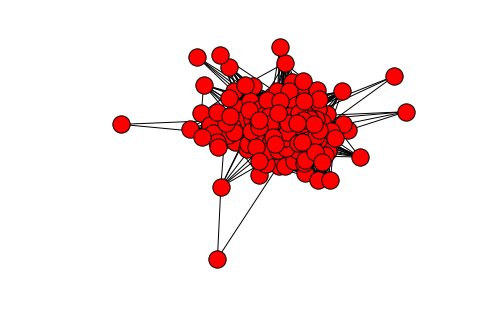

In [35]:
#The package which handles the graph objects
import networkx as nx

# Matplotlib is the default package for
# rendering the graphs
import matplotlib.pyplot as plt

def simple_graph(profile):

    #create an empty graph
    G = nx.Graph()
    
    name_mapping = {}
    
    for person in profile['items']:
        aid = person['member_id']
        name = person['name']
        surname = person['surname']
        name_mapping[aid] = name + " " + surname
        
    for person in profile['items']:
        aid = person['member_id']
        cite = person['2011-2015 citation stats']
        for au in cite.keys():
            edge = (aid, au)
            # name_edge = (name_mapping[aid], name_mapping[au])
            # G.add_edge(name_edge[0], name_edge[1])
            G.add_edge(str(edge[0]), str(edge[1]))
    
    #draw the graph
    nx.draw(G)
    # plt.savefig("graph.png", dpi=1000)
    #show
    plt.show()

    app = Viewer(G)
    app.mainloop()
simple_graph(orig_profile)

In [ ]:
def similarity_calculator(first, second):
    #if type(first) is not unicode:
    #    first = unicode(first, 'utf-8')
    #if type(second) is not unicode:
    #    second = unicode(second, 'utf-8')


    # 1. fuzzy matcher
    fr = fuzz.ratio(first, second)
    pr = fuzz.partial_ratio(first, second)
    sor = fuzz.token_sort_ratio(first, second)
    ser = fuzz.token_set_ratio(first, second)    
    
    # 2. sequence similarity
    s = difflib.SequenceMatcher(lambda x: x == " ", first, second)
    seq = round(s.ratio(), 3)
    
    # 3. edit distance
    # 3.1 absolute
    try:
        lv_ab = Levenshtein.distance(first, second)
    except:
        print "ooops", first, second
    
    # 3.2 jaro
    lv_ja = Levenshtein.jaro(first, second)
    
    # 3.3 jaro_winkler
    lv_jaw = Levenshtein.jaro_winkler(first, second)
    
    # 3.4 ratio
    lv_ra = Levenshtein.ratio(first, second)
    

    # 4 jarcard and 
    sr = distance.sorensen(first, second)
    ja = distance.jaccard(first, second)
    print fr, pr, sor, ser, seq, lv_ab, lv_ja, lv_jaw, lv_ra

In [ ]:
fuzz.ratio('Andersen, J\xf8rgen E.; Chekhov, Leonid O.; Penner, R. C.; Reidys, Christian M.; Su\u0142kowski, Piotr Topological recursion for chord diagrams, RNA complexes, and cells in moduli spaces. Nuclear Phys. B 866 (2013), no. 3, 414\u2013443.', \
           'Ande J\xf8rgen E.; Chekhov, Leonid O Penner, R. C.; Reidys, Christian M.; Su\u0142kowski, Piotr Topological recursion for chord diagrams, RNAcomplexes,and cells in moduli spaces. Nuclear Phys. B 866 (2013), no. 3, 4142013443.')

# Computer number of paper they wrote together between y1 and y2

In [ ]:
def count_coop(gid1, gid2, y1, y2):
    val = 0
    aid1 = base[gid1]
    aid2 = base[gid2]
    # print aid1, aid2
    papers_1 = paper_base[aid1]
    # papers_2 = paper_base[aid2]
    
    for paper in papers_1:
        if paper['year'] >= y1 and paper['year']<= y2:
            if aid2 in paper['authors']:
                val += 1
    return val
    

In [ ]:
# 24
# 12

In [ ]:
count_coop("24","12",1000,2016)

In [ ]:
data = {}
for a1 in base.keys():
    data[a1] = {}
    for a2 in base.keys():
        if a1 is not a2:
            data[a1][a2] = count_coop(a1, a2, 2011, 2011)

In [ ]:
with open("input.csv", "w") as f:
    f.write("Source;Target;Weight;Type\n")
    for a1 in data.keys():
        for a2 in data[a1].keys():
            if data[a1][a2] > 0:
                f.write(a1)
                f.write(";")
                f.write(a2)
                f.write(";")
                f.write(str(data[a1][a2]))
                f.write(";")
                f.write("undirected\n")

In [ ]:
def print_single_year(year):
    data = {}
    for a1 in base.keys():
        data[a1] = {}
        for a2 in base.keys():
            if a1 is not a2:
                data[a1][a2] = count_coop(a1, a2, year, year)
                
    with open(str(year)+"_input.csv", "w") as f:
        f.write("Source;Target;Weight;Type\n")
        for a1 in data.keys():
            for a2 in data[a1].keys():
                if data[a1][a2] > 0:
                    f.write(a1)
                    f.write(";")
                    f.write(a2)
                    f.write(";")
                    f.write(str(data[a1][a2]))
                    f.write(";")
                    f.write("undirected\n")

In [ ]:
print_single_year(2011)
print_single_year(2012)
print_single_year(2013)
print_single_year(2014)
print_single_year(2015)
print_single_year(2016)

# Combine databases

In [ ]:
orig = "Boileau, Michel; Boyer, Steven; Cebanu, Radu; Walsh, Genevieve S. Knot commensurability and the Berge conjecture. Geom. Topol. 16 (2012), no. 2, 625–664."
new = 'Knot commensurability and the Berge conjecture.'

In [ ]:
orig = "Steven B. Bradlow"
new = "Bradlow, S"

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import math
import wikipedia
import Levenshtein
import difflib
import distance
import textblob
import numpy

In [ ]:
import json
with open("papers.json") as f:
    old_base = json.loads(f.read())

In [ ]:
old_base.keys()

In [ ]:
paper_base

In [ ]:
# make a mapping from 
mapping = {}
for key in base.keys():
    mapping[base[key]] = key
    
mapping

In [ ]:
# go through paper_base, filter only 2011+ papers

out = []
for key in paper_base.keys():
    paper_list = paper_base[key]
    for paper in paper_list:
        if paper['year'] >= 2011:
            if check_if_coop(paper['authors'], mapping):
                newone = {}
                newone['collaborator_ids'] = get_ids(paper['authors'], mapping)
                newone['date'] = str(paper['year'])
                newone['description'] = paper['article_title']
                out.append(newone)

In [ ]:
out_base = []
for unit in out:
    f = True
    for exi in out_base:
        if unit['description'] == exi['description']:
            f = False
    if f:
        out_base.append(unit)
        

In [ ]:
len(out_base)

In [ ]:
out_base

In [ ]:
def check_if_coop(authors, mapping):
    val = 0
    for au in authors:
        if au in mapping.keys():
            val += 1
    if val>=2:
        return True
    else:
        return False
    
def get_ids(authors, mapping):
    ret = []
    for au in authors:
        if au in mapping.keys():
            ret.append(int(mapping[au]))
    return ret

In [ ]:
# out is auto database
# old_base is old database

final = []

for a in old_base['papers']:
    f = True
    for b in final:
        if title_compare(a, b) is True:
            f = False
    if f:
        final.append(a)
        
for a in out_base:
    f = True
    for b in final:
        if title_compare(a, b) is True:
            f = False
    if f:
        final.append(a)
        
        

In [ ]:
len(old_base['papers'])

In [ ]:
len(final)

In [ ]:
def title_compare(a, b):
    return fuzz.partial_ratio(a['description'], b['description'])>95

In [ ]:
def ids_compare(a, b):
    return set(a['collaborator_ids']) == set(b['collaborator_ids'])

In [ ]:
def date_compare(a, b):
    return a['date'] == b['date']

In [ ]:
with open("prof.txt", "r") as f:
    profile = json.loads(f.read())

In [ ]:
for prof in profile['items']:
    id = prof['member_id']
    try:
        prof[u'mathsci_id'] = mapping[id]
    except:
        prof[u'mathsci_id'] = 0

In [ ]:
profile

In [ ]:
import json
with open('new_profile.json', 'w') as outfile:
    json.dump(profile, outfile)

In [ ]:
import json
with open('new_papers.json', 'w') as outfile:
    json.dump(final, outfile)

In [ ]:
"ddd  ".strip()

In [ ]:
import collections

In [ ]:
a = [3,4,5,5,5,6]
b = [1,3,4,4,5,5,6,7]

a_multiset = collections.Counter(a)
b_multiset = collections.Counter(b)

overlap = list((a_multiset & b_multiset).elements())

In [ ]:
overlap

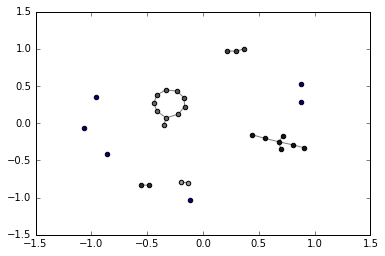

In [20]:
import community
import networkx as nx
import matplotlib.pyplot as plt

#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
G = nx.erdos_renyi_graph(30, 0.05)

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [ ]:
%matplotlib inline  
import matplotlib.pyplot as plt




In [ ]:
import matplotlib.pyplot as plt
